# 机器学习作业二：回归模型
- 姓名：
- 学号：
- 专业：

### 实验要求
回归是监督学习的一个重要问题，回归用于预测输入变量和输出变量之间的关系，特别是当输入变量的值发生变化时，输出变量的值也随之发生变化。回归模型是一种表示从输入变量到输出变量之间映射的函数对连续值的预测可以用合适的曲线揭示样本点随着自变量的变化关系

题目：
1. 基本要求：将数据集winequality-white.csv按照4:1划分为训练集和测试集。构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。特别需要注意：划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。需要对数据集进行一定的预处理
2. 中级要求：探究回归模型在机器学习和统计学上的差异。回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。
3. 高级要求:编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）。

**截止日期：10月21日**
- 以.ipynb形式的文件提交，输出运行结果，并确保自己的代码能够正确运行
- 发送到邮箱：2120220594@mail.nankai.edu.cn

### 导入需要的包

In [37]:
import numpy as np
import operator
from collections import Counter
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd

### 导入数据集 semesion

In [38]:

data = pd.read_csv("winequality-white.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# 一. 基本要求
将数据集winequality-white.csv按照4:1划分为训练集和测试集。构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。特别需要注意：划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。需要对数据集进行一定的预处理
## 1. 数据预处理

In [39]:
# 中心化
def Normalization_fun(x):
    # 特征零均值
    x = (x - np.mean(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x


# 归一化
def feature_scaling(x):
    x=np.array(x)
    for i in range(len(x[0])):
        max = -float('inf')
        min = float('inf') 
        for m in range(len(x)):
            if x[m][i] > max:
                max = x[m][i]
            if x[m][i] < min:
                min = x[m][i]
        for m in range(len(x)):
            if max - min != 0:
                x[m][i] = (x[m][i] - min) / (max - min)
    return x

(array([  83.,  931., 1440., 1402.,  595.,  263.,  134.,   26.,   20.,
           4.]),
 array([0.22 , 0.306, 0.392, 0.478, 0.564, 0.65 , 0.736, 0.822, 0.908,
        0.994, 1.08 ]),
 <BarContainer object of 10 artists>)

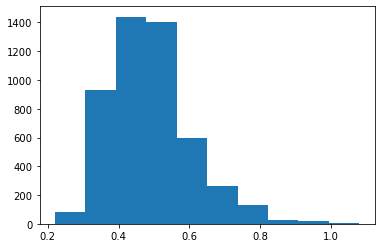

In [40]:
# 数据预处理
X = data.iloc[:, 0:-1]
data.iloc[:, 0:-1] = Normalization_fun(X)
# 可视化中心化后的sulphates特征
import matplotlib.pyplot as plt
plt.hist(X["sulphates"])
plt.show()

## 2. 划分训练集和测试集
### 使用分层采样对数据进行4：1划分处理

分层抽样4:1结果展示：


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'quality')

Text(0, 0.5, 'number')

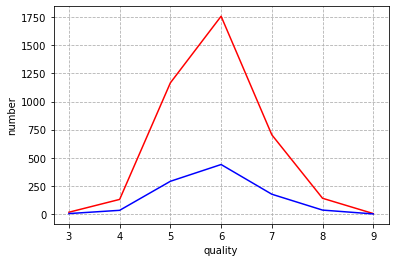

In [41]:
train_rate = 0.8 # 划分比例
# data.describe()
# 分层抽样得到训练集数据
train_data = data.groupby('quality').apply(lambda group : group.sample(frac=train_rate)) 
train_data.index = train_data.index.droplevel()
# 测试集数据
test_data = data[~data.index.isin(train_data.index)] 
# 重置索引
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# 对分层抽样(4:1)的结果进行展示
print("分层抽样4:1结果展示：")
x_index = range(3,10)
y_num_train = train_data.groupby('quality').apply(lambda group : group)['quality'].value_counts()[x_index]
y_num_test = test_data.groupby('quality').apply(lambda group : group)['quality'].value_counts()[x_index]
plt.figure()
plt.plot(x_index,y_num_train, 'r')
plt.plot(x_index,y_num_test, 'b')
plt.grid(linestyle="--")
plt.xlabel("quality")
plt.ylabel("number")
# 显示图
plt.show()

In [42]:
# 提取数据特征和标签
train_X = train_data.iloc[:, 0:-1]
test_X = test_data.iloc[:, 0:-1]
train_Y = train_data.iloc[:, -1]
test_Y = test_data.iloc[:, -1]

# 在训练集和测试集左侧添加全为1的列
train_X = pd.concat([pd.DataFrame(np.ones(train_X.shape[0]), columns=['x0']), train_X], axis=1)
test_X = pd.concat([pd.DataFrame(np.ones(test_X.shape[0]), columns=['x0']), test_X], axis=1)
# 将数据转换为numpy.ndarray格式
train_X = np.array(train_X)
train_Y = np.array(train_Y)
train_Y = train_Y.reshape(-1, 1)
test_X = np.array(test_X)
test_Y = np.array(test_Y)
test_Y = test_Y.reshape(-1, 1)
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((3918, 12), (3918, 1), (980, 12), (980, 1))

## 3. 批量梯度下降和随机梯度下降

In [92]:
# 初始化回归系数
W_init = np.random.randn(train_X.shape[1], 1)
W_init

array([[-0.69066785],
       [ 0.06426571],
       [ 1.42791695],
       [-0.40584158],
       [ 1.42590226],
       [-1.82061481],
       [-0.71798247],
       [-0.15603707],
       [ 0.47053755],
       [ 0.62918957],
       [ 0.37480496],
       [ 0.00272495]])

In [93]:
# 定义MSE
def MSE(X, Y, W):
    return np.sum(np.power((np.dot(X, W) - Y), 2)) / Y.size

###  (1) 批量梯度下降

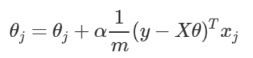

In [119]:
# 批量梯度下降
def BGD(train_X, train_Y, test_X, test_Y, theta, alpha, epochs):
    theta = copy.deepcopy(theta)
    BGD_MSE_train = []
    BGD_MSE_test = []
    BGD_MSE_train.append(MSE(train_X, train_Y, theta))
    BGD_MSE_test.append(MSE(test_X, test_Y, theta))
    for i in range(epochs):
        for j in range(theta.size):
            Xj = train_X[:, j].reshape(-1, 1)
            theta[j] = theta[j] + alpha * np.sum((train_Y - np.dot(train_X, theta)) * Xj) / train_Y.size
        BGD_MSE_train.append(MSE(train_X, train_Y, theta))
        BGD_MSE_test.append(MSE(test_X, test_Y, theta))
    return theta, BGD_MSE_train, BGD_MSE_test

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'quality')

Text(0, 0.5, 'number')

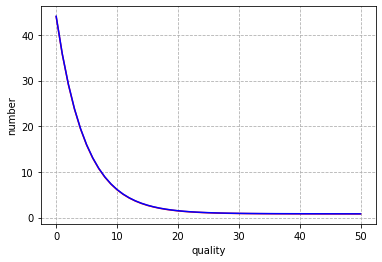

array([[ 5.8426812 ],
       [ 0.03775017],
       [ 1.2765246 ],
       [-0.38323107],
       [ 1.36479832],
       [-1.84309199],
       [-0.70177641],
       [-0.22136125],
       [ 0.38370723],
       [ 0.6444554 ],
       [ 0.38377048],
       [ 0.34370331]])

In [120]:
alpha = 0.1
epochs = 50
BGD_theta, BSD_MSE_train, BSD_MSE_test = BGD(train_X, train_Y, test_X, test_Y, W_init, alpha, epochs)
plt.figure()
plt.plot(range(epochs+1),BSD_MSE_train, 'r')
plt.plot(range(epochs+1),BSD_MSE_test, 'b')
plt.grid(linestyle="--")
plt.xlabel("quality")
plt.ylabel("number")
# 显示图
plt.show()
BGD_theta

### (2) 随机梯度下降

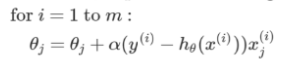

In [123]:
# 随机梯度下降
def SGD(train_X, train_Y, test_X, test_Y, theta, alpha, epochs):
    train_X = copy.deepcopy(train_X)
    theta = copy.deepcopy(theta)
    SGD_MSE_train= []
    SGD_MSE_test = []
    SGD_MSE_train.append(MSE(train_X, train_Y, theta))
    SGD_MSE_test.append(MSE(test_X, test_Y, theta))
    for i in range(epochs):
        np.random.shuffle(train_X)
        for k in range(train_Y.size):
            Y_i = train_Y[epochs, :].reshape(-1, 1)
            X_i = train_X[epochs, :].reshape(1, -1)
            for j in range(theta.size):
                Xj = train_X[i, j].reshape(-1, 1)
                theta[j] = theta[j] + alpha * np.sum((Y_i - np.dot(X_i, theta)) * Xj)
        SGD_MSE_train.append(MSE(train_X,train_Y, theta))
        SGD_MSE_test.append(MSE(test_X, test_Y, theta))
    return theta, SGD_MSE_train, SGD_MSE_test

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'quality')

Text(0, 0.5, 'number')

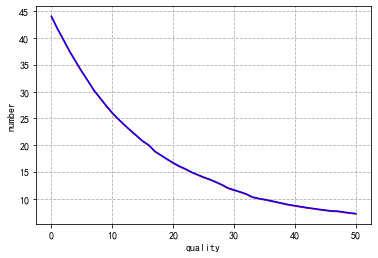

array([[ 3.36647586],
       [ 0.00515639],
       [ 1.41713645],
       [-0.4284679 ],
       [ 1.48049169],
       [-1.76674941],
       [-0.6850289 ],
       [-0.0627109 ],
       [ 0.49934095],
       [ 0.64952512],
       [ 0.29259012],
       [-0.09176369]])

In [134]:
alpha = 0.00001
epochs = 50
SGD_theta, SGD_MSE_train, SGD_MSE_test = SGD(train_X, train_Y, test_X, test_Y, W_init, alpha, epochs)
plt.figure()
plt.plot(range(epochs+1),SGD_MSE_train, 'r')
plt.plot(range(epochs+1),SGD_MSE_test, 'b')
plt.grid(linestyle="--")
plt.xlabel("quality")
plt.ylabel("number")
# 显示图
plt.show()
SGD_theta

## 4. 探究BGD和SGD不同学习率MSE曲线
综合上面两幅图像收敛效果,我们固定学习轮数为50轮。对于批量梯度下降和随机梯度下降，我们均设置学习率为1.5、1、0.1、0.01、0.001进行测试

In [131]:
# 训练轮数
epochs = 50
# 学习率
alphas = [2, 1, 0.5, 0.1, 0.01, 0.001]
BGD_train = []
BGD_test = []
SGD_train = []
SGD_test = []
for alpha in alphas:
    BGD_theta, BSD_MSE_train, BSD_MSE_test = BGD(train_X, train_Y, test_X, test_Y, W_init, alpha, epochs)
    BGD_train.append(BSD_MSE_train)
    BGD_test.append(BSD_MSE_test)
for alpha in alphas:
    SGD_theta, SGD_MSE_train, SGD_MSE_test= SGD(train_X, train_Y, test_X, test_Y, W_init, alpha, epochs)
    SGD_train.append(SGD_MSE_train)
    SGD_test.append(SGD_MSE_test)

C:\Users\nie'zhi'qiang\AppData\Local\Temp\ipykernel_14076\1979619471.py:3: RuntimeWarning: overflow encountered in power
  return np.sum(np.power((np.dot(X, W) - Y), 2)) / Y.size
C:\Users\nie'zhi'qiang\AppData\Local\Temp\ipykernel_14076\570782488.py:16: RuntimeWarning: overflow encountered in double_scalars
  theta[j] = theta[j] + alpha * np.sum((Y_i - np.dot(X_i, theta)) * Xj)


<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, '批量梯度下降-训练集')

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, '批量梯度下降-测试集')

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, '随机梯度下降-训练集')

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, '随机梯度下降-测试集')

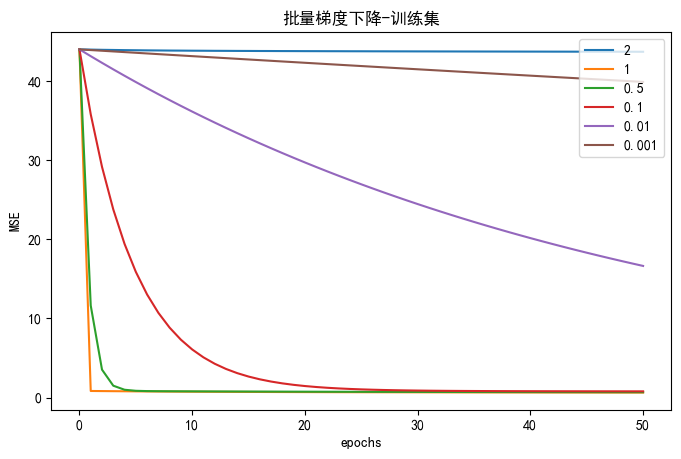

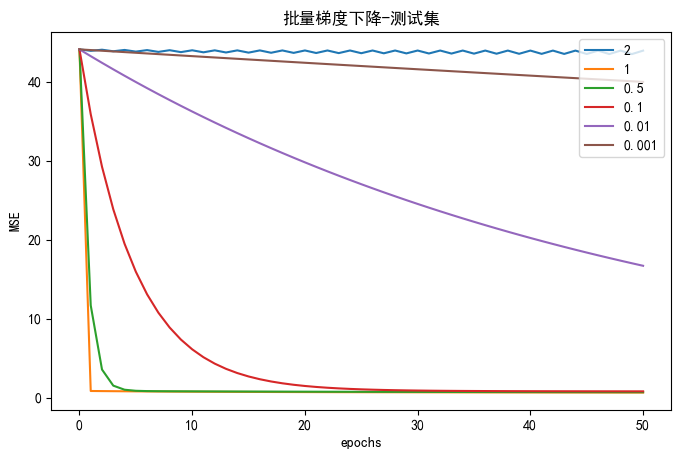

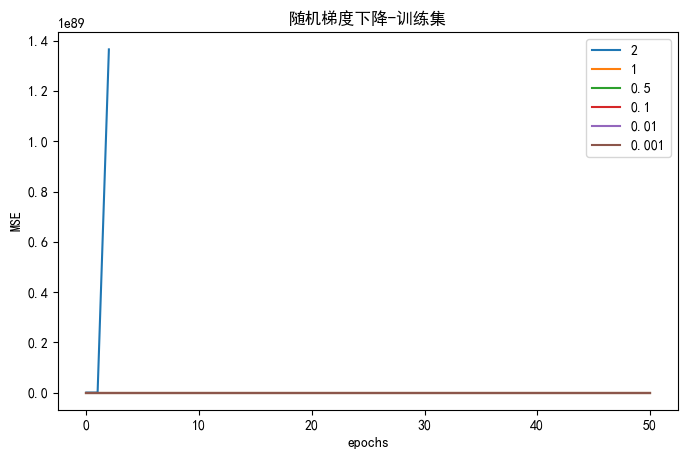

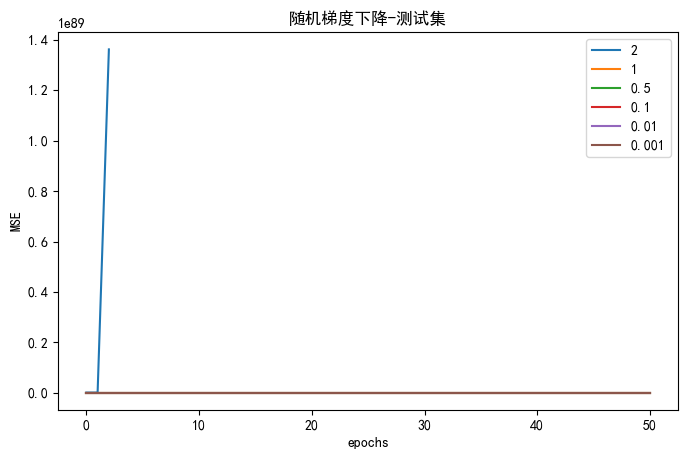

In [132]:
# 画图
plt.rcParams['font.sans-serif']=['SimHei']   #用来正常显示中文标签
# 批量梯度下降-训练集
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("批量梯度下降-训练集")
for i in range(len(alphas)):
    plt.plot(range(epochs + 1), BGD_train[i])
plt.legend(alphas,loc='upper right')

# 批量梯度下降-测试集
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("批量梯度下降-测试集")
for i in range(len(alphas)):
    plt.plot(range(epochs + 1), BGD_test[i])
plt.legend(alphas,loc='upper right')

# 随机梯度下降-训练集
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("随机梯度下降-训练集")
for i in range(len(alphas)):
    plt.plot(range(epochs + 1), SGD_train[i])
plt.legend(alphas,loc='upper right')

# 随机梯度下降-测试集
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("随机梯度下降-测试集")
for i in range(len(alphas)):
    plt.plot(range(epochs + 1), SGD_test[i])
plt.legend(alphas,loc='upper right')
plt.show()

#### 实验过程调整
发现上图中随机梯度下降MSE曲线因为某个学习率导致MSE值和其他学习率的对应的MSE值产生量级上的差异,因此重新设定随机梯度下降测试集和训练集学习率的探究值,以便于观察不同学习率对于随机梯度下降MSE的变化,经过多次实验,当取学习率为 0.1, 0.01, 0.001, 0.0001,000001 最为合适,且改边epochs最大训练论数为30即可发现曲线拟合,具体实验代码及效果如下图所示

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, '随机梯度下降-训练集')

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, '随机梯度下降-测试集')

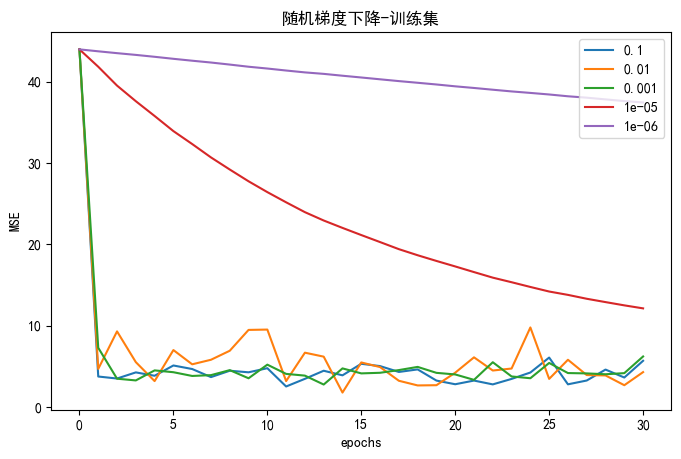

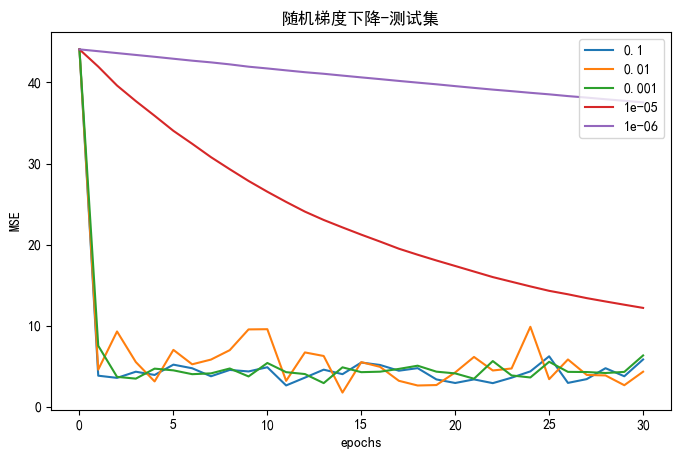

In [135]:
# 训练轮数
epochs =30
# 学习率
alphas = [0.1, 0.01, 0.001,0.00001,0.000001]
BGD_train = []
BGD_test = []
SGD_train = []
SGD_test = []
for alpha in alphas:
    SGD_theta, SGD_MSE_train, SGD_MSE_test= SGD(train_X, train_Y, test_X, test_Y, W_init, alpha, epochs)
    SGD_train.append(SGD_MSE_train)
    SGD_test.append(SGD_MSE_test)

# 随机梯度下降-训练集
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("随机梯度下降-训练集")
for i in range(len(alphas)):
    plt.plot(range(epochs + 1), SGD_train[i])
plt.legend(alphas,loc='upper right')

# 随机梯度下降-测试集
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("随机梯度下降-测试集")
for i in range(len(alphas)):
    plt.plot(range(epochs + 1), SGD_test[i])
plt.legend(alphas,loc='upper right')
plt.show()

### 不同学习率对MSE曲线影响分析
#### 结论一:
通过 二(4) 中第一二幅图可知, 对于批量梯度下降回归, 当学习率较大时模型收敛过慢, 当学习率过小时, 曲线收敛效果也不好, 当学习率处于0.1~1之间时，MSE曲线收敛效果较好. 对于随机梯度下降回归, 当学习率很小(例如1e-06)时, 模型的收敛结果不好，当学习率适中(例如0.001)时, 收敛迅速但收敛后出现波动. 对比以上结果, 可知相比随机梯度下降, 批量梯度下降效果更好.

#### 结论二:
学习率大小依据不同模型不能一概而论, 类似我上面出现的情况,随机梯度下降和批量梯度下降对于相同学习率敏感程度不同, 因此要"因地制宜"选取合适的学习率区间做测试,以便观察不同学习率对于损失的影响

#### 结论三:
训练论述大小测试也要依据具体情况具体分析, 例如上述随机梯度下降比批量梯度下降收敛更快, 因此对于随机梯度下降可以减少eoochs(能涵盖收敛即可),这样可以节约训练时间, 而且就我自己做深度学习而言, 海量数据/大模型训练一轮真的很耗时, 如果GPU不给力的话那就真的很顶了.

## 三. 中级要求
### 回归模型在机器学习和统计学上的差异

### 1. 定义
- 机器学习:一种不依赖于规则设计的数据学习算法。
- 统计模型：以数学方程形式表现变量之间关系的程式化表达

### 3. 机器学习与统计学中线性回归概念的不同
- 线性回归是一种统计方法，我们训练线性回归量并获得与统计回归模型相同的结果，旨在最小化数据点之间的平方误差。
- 在统计学中，线性回归（Linear regression）是利用称为线性回归方程的最小二乘函数对一个或多个自变量和因变量之间关系进行建模的一种回归分析。多项式曲线拟合(Fitting)则是将线性回归推广到了高阶函数中。
- 机器学习中的线性回归和多项式拟合是有监督学习方法。

### 4. 回归模型在机器学习和统计学上的差异
- 对于统计模型，我们只要找出可以最小化所有数据的均方误差（假设数据是一个线性回归量，加上一些随机噪声，本质上通常是高斯噪声），无需训练，也无需测试。
- （受监督的）机器学习的目的是获得可以进行可重复预测的模型。我们通常不关心模型是否可解释，机器学习只看重结果。而统计建模更多的是发现变量之间的关系和这些关系的重要性，同时也适合预测。

这两种方法的目标不同，尽管使用的方法类似。机器学习算法的评估使用测试集来验证其准确性。统计模型可以使用置信区间，显着性检验和其他检验对回归参数进行分析，以评估模型的合法性。

## 四. 高级要求
### 1. 岭回归实现

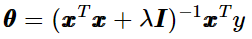

In [137]:
def RidgeRegression(train_X, train_Y, L2_lambda):  # 设置岭系数为0.2
    xMat = np.mat(train_X)
    yMat = np.mat(train_Y)
    xTx = xMat.T * xMat
    rxTx = xTx + np.eye(xMat.shape[1]) * L2_lambda
    # 计算矩阵的值,如果值为0，说明该矩阵没有逆矩阵
    if np.linalg.det(rxTx) == 0.0:
        return
    theta = rxTx.I * xMat.T * yMat
    return theta

In [154]:
theta = RidgeRegression(train_X, train_Y,0.2)
train_MSE = MSE(train_X, train_Y, ws)
test_MSE = MSE(test_X, test_Y, ws)
print("平均训练误差为:")
print(train_MSE)
print(f"平均测试误差为:")
print(test_MSE)

平均训练误差为:
0.5637717577994162
平均测试误差为:
0.5701696809534088
